In [7]:
from sklearn.manifold import TSNE
from collections import Counter
from six.moves import cPickle
import gensim.models.word2vec as w2v
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
import os
import sys
import io
import re
import json
import pickle
import pandas as pd
import glob

In [8]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding

## Plotly
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

# Others

import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer 

from sklearn.manifold import TSNE
from gensim.models import word2vec

In [10]:
convote_train_files_path = 'data_stage_one/training_set/*.txt'
convote_test_files_path = 'data_stage_one/test_set/*.txt'

In [11]:
convote_train_files = glob.glob(convote_train_files_path)
convote_test_files = glob.glob(convote_test_files_path)

In [12]:
filepath_dict = {'convote_train': convote_train_files,
                 'convote_test': convote_test_files}

In [13]:
convote_data = []

for data_type, filenames in filepath_dict.items():
    for i in range(len(filenames)):
        f = open(filenames[i], 'r')
        f_text = f.read()
        #print(f_text)
        f.close()
        party = filenames[i].split('_')[-1][0]
        sample_group = data_type.split('_')[-1]
        #print(review_sentiment)
        review_label = 0 if party == 'D' else 1
        #print(review_label)
        convote_data.append([f_text, party, sample_group, review_label])
      

In [14]:
convote_data = pd.DataFrame(convote_data)

In [15]:
convote_data = convote_data.rename(index=str, columns={0: 'text', 1: 'party', 2: 'group', 3: 'party_label'})

In [33]:
def clean_text(text):
    #remove punctuation
    text = text.translate(string.punctuation)
    
    ## Convert words to lower case and split them
    text = text.lower().split()
    
    ## Remove stop words
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops and len(w) > 2]
    
    text = " ".join(text)

    ## Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    
 
    # Tokenize: Split the sentence into words
    tokens = nltk.word_tokenize(text)
  
    #lemmatize the text   

    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in tokens]
    text = " ".join(lemmatized_words)
    return text

# apply the above function to df['text']


In [34]:
# apply the above function to df['text']

convote_data['text'] = convote_data['text'].map(lambda x: clean_text(x))

In [35]:
democrats = convote_data.loc[convote_data['party_label'] == 0]
republicans = convote_data.loc[convote_data['party_label'] == 1]

In [74]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=15, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

### TSNE on entire Convote

In [69]:
convote_words=[]
for i in range(len(convote_data)):
    convote_words.append(convote_data['text'].values[i].split())

In [77]:
convote_wmodel = word2vec.Word2Vec(convote_words, size=100, window=2, min_count=600, workers=4)

/home/avanti/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



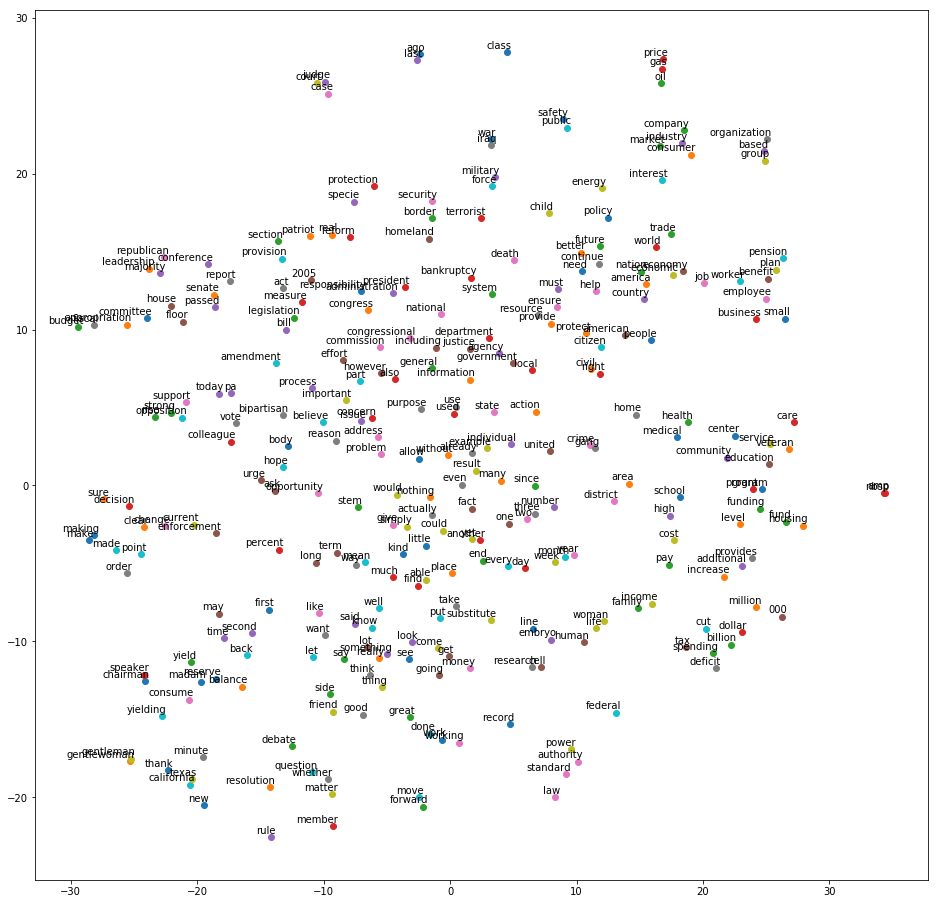

In [79]:
tsne_plot(convote_wmodel)

### Word2Vec TSNE for democrats

In [61]:
dem_words=[]
for i in range(len(democrats)):
    dem_words.append(democrats['text'].values[i].split())

In [64]:
dem_wmodel = word2vec.Word2Vec(dem_words, size=100, window=2, min_count=400, workers=4)

/home/avanti/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



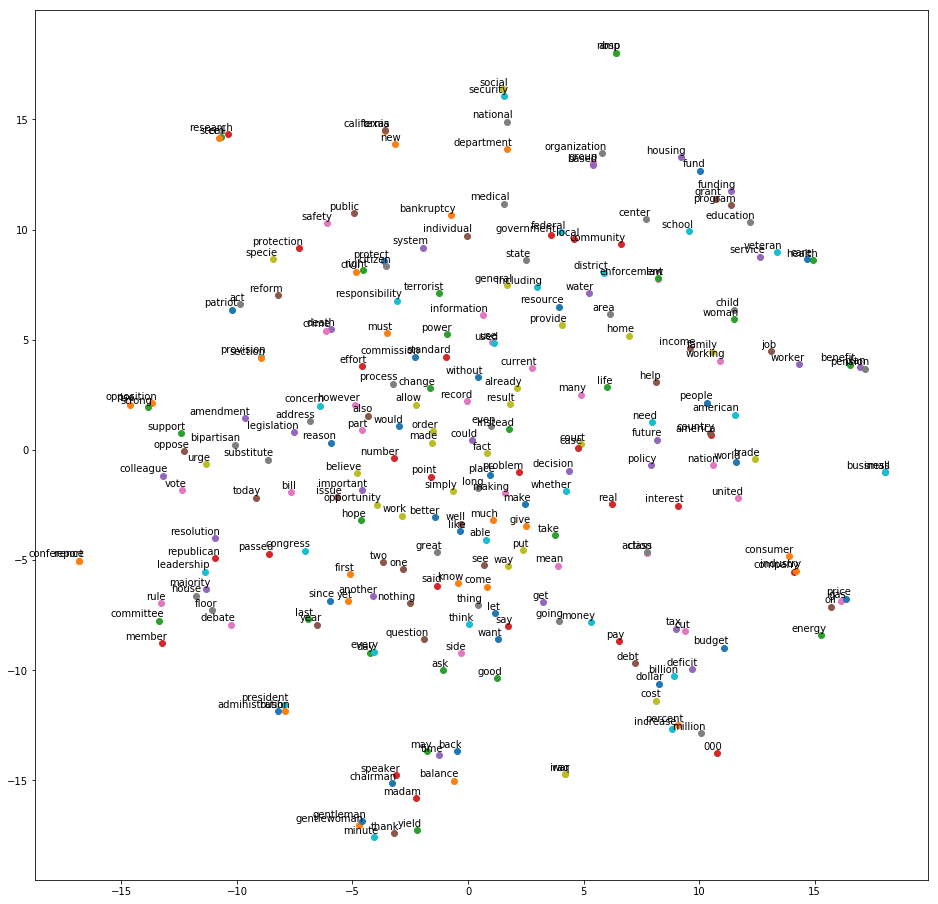

In [65]:
tsne_plot(dem_wmodel)

### Word2Vec TSNE for republican

In [66]:
rep_words=[]
for i in range(len(republicans)):
    rep_words.append(republicans['text'].values[i].split())

In [67]:
rep_wmodel = word2vec.Word2Vec(rep_words, size=100,window=2, min_count=400, workers=4)

/home/avanti/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



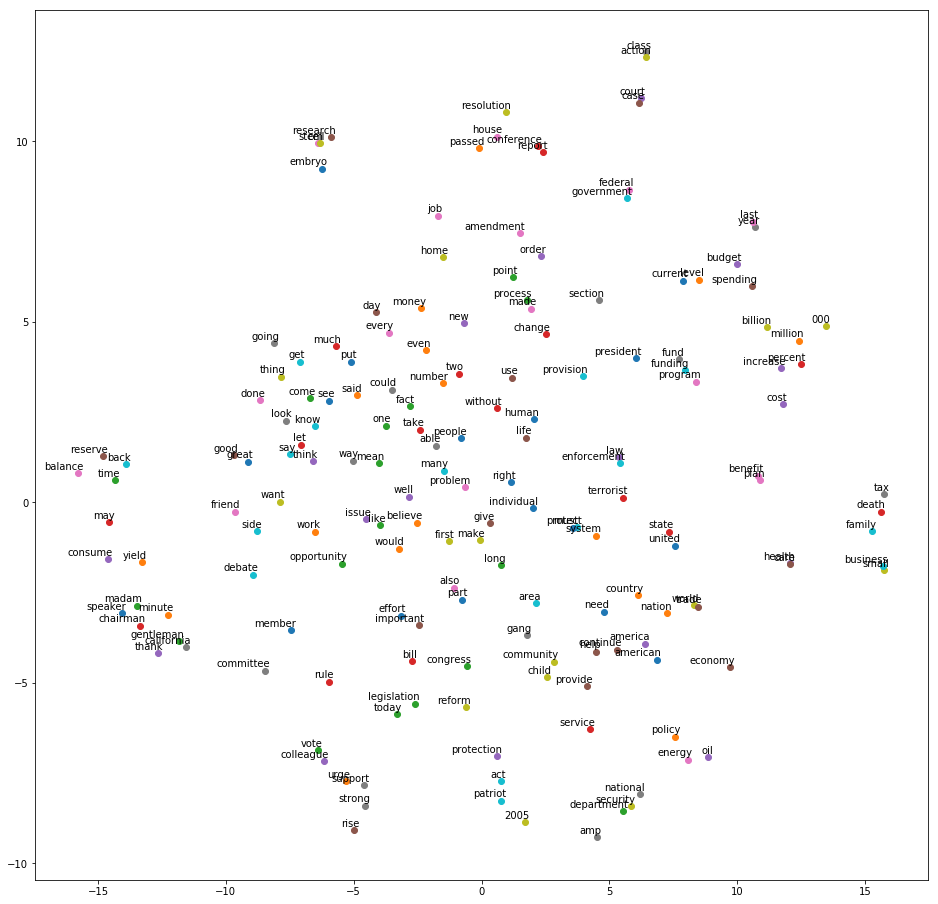

In [68]:
tsne_plot(rep_wmodel)